In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [2]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.3
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [3]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True, transform=data_transforms['test']),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Check Images

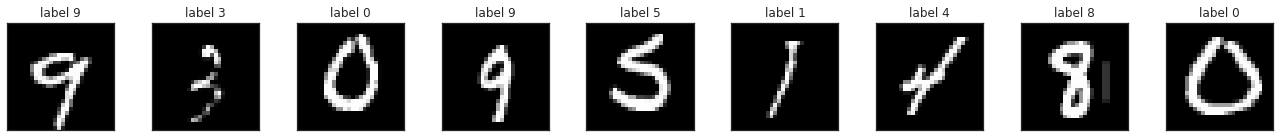

In [4]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=80)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [6]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Train Teacher Model

==========> Teacher model
02:27:10 --- Epoch: 1	Train loss: 0.2246	Valid loss: 0.0993	Train accuracy: 95.45	Valid accuracy: 96.77
02:27:56 --- Epoch: 3	Train loss: 0.1408	Valid loss: 0.0695	Train accuracy: 97.08	Valid accuracy: 97.74
02:28:42 --- Epoch: 5	Train loss: 0.1115	Valid loss: 0.0552	Train accuracy: 97.54	Valid accuracy: 98.21
02:29:28 --- Epoch: 7	Train loss: 0.0969	Valid loss: 0.0481	Train accuracy: 97.98	Valid accuracy: 98.57
02:30:14 --- Epoch: 9	Train loss: 0.0870	Valid loss: 0.0461	Train accuracy: 98.07	Valid accuracy: 98.59
02:31:00 --- Epoch: 11	Train loss: 0.0781	Valid loss: 0.0388	Train accuracy: 98.37	Valid accuracy: 98.77
02:31:47 --- Epoch: 13	Train loss: 0.0735	Valid loss: 0.0416	Train accuracy: 98.49	Valid accuracy: 98.71
02:32:33 --- Epoch: 15	Train loss: 0.0659	Valid loss: 0.0353	Train accuracy: 98.60	Valid accuracy: 98.84
02:33:18 --- Epoch: 17	Train loss: 0.0631	Valid loss: 0.0351	Train accuracy: 98.65	Valid accuracy: 98.81
02:34:04 --- Epoch: 19	Train loss:

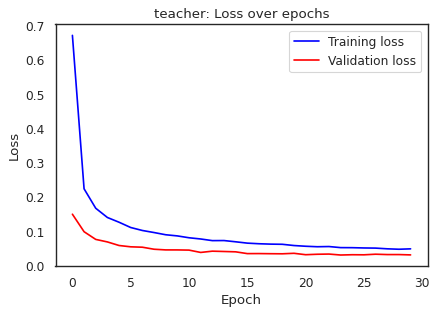


teacher model valid accuracy: 0.9899


In [7]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.015
N_EPOCHS = 30
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, test_loader, DEVICE)
print(f"\nteacher model valid accuracy: {valid_acc:.4f}")

### Train Student Model
#### Q2
Train student model base on groud Truth

=======> Student trained on Ground Truth
02:38:41 --- Epoch: 1	Train loss: 0.1921	Valid loss: 0.1052	Train accuracy: 95.24	Valid accuracy: 96.71
02:39:27 --- Epoch: 3	Train loss: 0.1177	Valid loss: 0.0772	Train accuracy: 96.73	Valid accuracy: 97.60
02:40:13 --- Epoch: 5	Train loss: 0.0893	Valid loss: 0.0581	Train accuracy: 97.44	Valid accuracy: 98.03
02:40:58 --- Epoch: 7	Train loss: 0.0750	Valid loss: 0.0487	Train accuracy: 97.86	Valid accuracy: 98.40
02:41:44 --- Epoch: 9	Train loss: 0.0660	Valid loss: 0.0447	Train accuracy: 98.22	Valid accuracy: 98.48
02:42:29 --- Epoch: 11	Train loss: 0.0563	Valid loss: 0.0396	Train accuracy: 98.41	Valid accuracy: 98.68
02:43:15 --- Epoch: 13	Train loss: 0.0507	Valid loss: 0.0452	Train accuracy: 98.42	Valid accuracy: 98.58
02:44:00 --- Epoch: 15	Train loss: 0.0482	Valid loss: 0.0346	Train accuracy: 98.63	Valid accuracy: 98.81
02:44:46 --- Epoch: 17	Train loss: 0.0437	Valid loss: 0.0389	Train accuracy: 98.80	Valid accuracy: 98.77
02:45:31 --- Epoch:

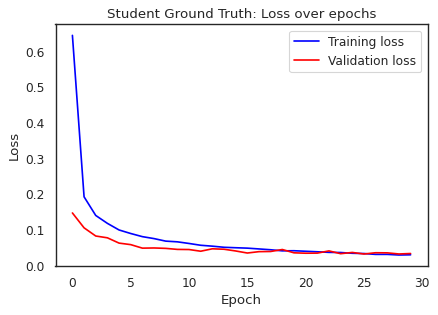


student model valid accuracy: 0.9896


In [8]:
print(f"=======> Student trained on Ground Truth")

LEARNING_RATE = 0.015
N_EPOCHS = 30

model_s_true = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true, optimizer, _ = training_loop(model_s_true, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2)
torch.save(model_s_true.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

Train student model base on teacher's soft label

=======> Student trained on Soft Label
02:50:07 --- Epoch: 1	Train loss: 0.3268	Valid loss: 0.0452	Train accuracy: 98.06	Valid accuracy: 98.51
02:50:55 --- Epoch: 3	Train loss: 0.1760	Valid loss: 0.0373	Train accuracy: 98.46	Valid accuracy: 98.78
02:51:42 --- Epoch: 5	Train loss: 0.1358	Valid loss: 0.0374	Train accuracy: 98.68	Valid accuracy: 98.75
02:52:29 --- Epoch: 7	Train loss: 0.1155	Valid loss: 0.0354	Train accuracy: 98.66	Valid accuracy: 98.81
02:53:17 --- Epoch: 9	Train loss: 0.1038	Valid loss: 0.0337	Train accuracy: 98.72	Valid accuracy: 98.88
02:54:04 --- Epoch: 11	Train loss: 0.0953	Valid loss: 0.0336	Train accuracy: 98.80	Valid accuracy: 98.86
02:54:51 --- Epoch: 13	Train loss: 0.0886	Valid loss: 0.0330	Train accuracy: 98.80	Valid accuracy: 98.90
02:55:38 --- Epoch: 15	Train loss: 0.0835	Valid loss: 0.0322	Train accuracy: 98.87	Valid accuracy: 98.98
02:56:25 --- Epoch: 17	Train loss: 0.0785	Valid loss: 0.0325	Train accuracy: 98.87	Valid accuracy: 98.96
02:57:12 --- Epoch: 1

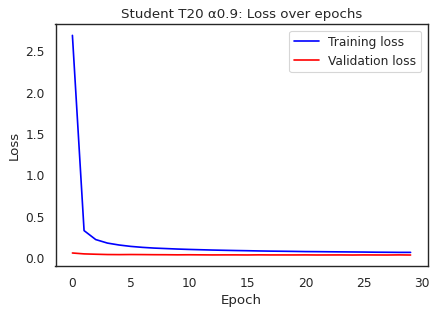


student model valid accuracy: 0.9900


In [9]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
LEARNING_RATE = 0.015
N_EPOCHS = 30
ALPHA = 0.9

print(f"=======> Student trained on Soft Label")
model_s_soft = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE, momentum=0.9)

valid_criterion = nn.CrossEntropyLoss()
train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
print(f"\nstudent model valid accuracy: {valid_acc:.4f}")

#### Q3
Different Temprature

=======> Temperature: 2
=======> Teacher model trained with Temperature 2
04:14:51 --- Epoch: 1	Train loss: 0.2589	Valid loss: 0.1113	Train accuracy: 94.79	Valid accuracy: 96.68
04:15:37 --- Epoch: 3	Train loss: 0.1583	Valid loss: 0.0785	Train accuracy: 96.58	Valid accuracy: 97.64
04:16:23 --- Epoch: 5	Train loss: 0.1235	Valid loss: 0.0650	Train accuracy: 97.10	Valid accuracy: 97.98
04:17:09 --- Epoch: 7	Train loss: 0.1046	Valid loss: 0.0517	Train accuracy: 97.65	Valid accuracy: 98.42
04:17:54 --- Epoch: 9	Train loss: 0.0922	Valid loss: 0.0482	Train accuracy: 98.03	Valid accuracy: 98.46
04:18:40 --- Epoch: 11	Train loss: 0.0846	Valid loss: 0.0450	Train accuracy: 98.16	Valid accuracy: 98.58
04:19:26 --- Epoch: 13	Train loss: 0.0776	Valid loss: 0.0446	Train accuracy: 98.25	Valid accuracy: 98.44


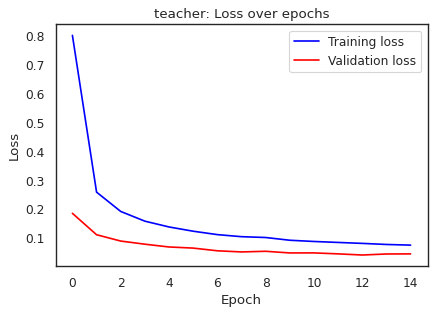

=======> Student model trained with Temperature 2
04:20:29 --- Epoch: 1	Train loss: 0.1274	Valid loss: 0.0707	Train accuracy: 96.90	Valid accuracy: 97.84
04:21:16 --- Epoch: 3	Train loss: 0.0487	Valid loss: 0.0531	Train accuracy: 97.78	Valid accuracy: 98.45
04:22:03 --- Epoch: 5	Train loss: 0.0351	Valid loss: 0.0478	Train accuracy: 98.03	Valid accuracy: 98.51
04:22:51 --- Epoch: 7	Train loss: 0.0281	Valid loss: 0.0493	Train accuracy: 98.15	Valid accuracy: 98.47
04:23:38 --- Epoch: 9	Train loss: 0.0247	Valid loss: 0.0460	Train accuracy: 98.22	Valid accuracy: 98.56
04:24:25 --- Epoch: 11	Train loss: 0.0222	Valid loss: 0.0463	Train accuracy: 98.21	Valid accuracy: 98.51
04:25:12 --- Epoch: 13	Train loss: 0.0213	Valid loss: 0.0441	Train accuracy: 98.28	Valid accuracy: 98.63


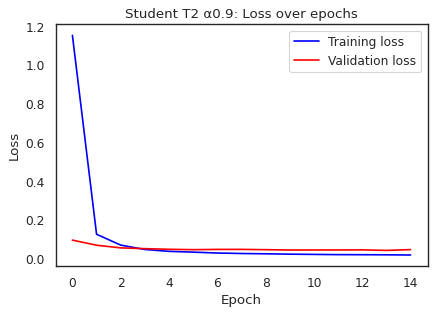


student model valid accuracy: 0.9852
=======> Temperature: 3
=======> Teacher model trained with Temperature 3
04:26:16 --- Epoch: 1	Train loss: 0.2570	Valid loss: 0.1139	Train accuracy: 94.91	Valid accuracy: 96.57
04:27:03 --- Epoch: 3	Train loss: 0.1561	Valid loss: 0.0869	Train accuracy: 96.00	Valid accuracy: 97.32
04:27:49 --- Epoch: 5	Train loss: 0.1234	Valid loss: 0.0619	Train accuracy: 97.23	Valid accuracy: 97.95
04:28:35 --- Epoch: 7	Train loss: 0.1059	Valid loss: 0.0503	Train accuracy: 97.73	Valid accuracy: 98.40
04:29:21 --- Epoch: 9	Train loss: 0.0925	Valid loss: 0.0498	Train accuracy: 97.94	Valid accuracy: 98.37
04:30:08 --- Epoch: 11	Train loss: 0.0858	Valid loss: 0.0414	Train accuracy: 98.15	Valid accuracy: 98.65
04:30:54 --- Epoch: 13	Train loss: 0.0802	Valid loss: 0.0401	Train accuracy: 98.31	Valid accuracy: 98.76


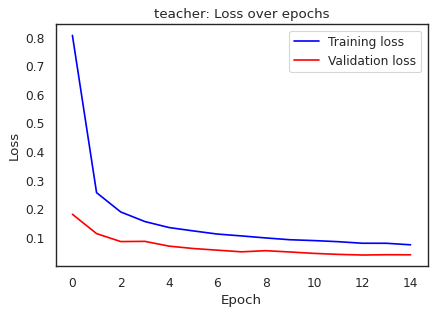

=======> Student model trained with Temperature 3
04:31:58 --- Epoch: 1	Train loss: 0.1313	Valid loss: 0.0544	Train accuracy: 97.44	Valid accuracy: 98.26
04:32:45 --- Epoch: 3	Train loss: 0.0602	Valid loss: 0.0468	Train accuracy: 97.84	Valid accuracy: 98.48
04:33:32 --- Epoch: 5	Train loss: 0.0462	Valid loss: 0.0441	Train accuracy: 97.99	Valid accuracy: 98.54
04:34:20 --- Epoch: 7	Train loss: 0.0388	Valid loss: 0.0452	Train accuracy: 98.06	Valid accuracy: 98.52
04:35:07 --- Epoch: 9	Train loss: 0.0348	Valid loss: 0.0423	Train accuracy: 98.18	Valid accuracy: 98.59
04:35:54 --- Epoch: 11	Train loss: 0.0322	Valid loss: 0.0426	Train accuracy: 98.18	Valid accuracy: 98.60
04:36:42 --- Epoch: 13	Train loss: 0.0297	Valid loss: 0.0419	Train accuracy: 98.23	Valid accuracy: 98.60


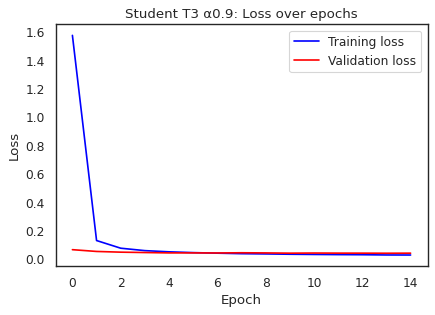


student model valid accuracy: 0.9864
=======> Temperature: 4
=======> Teacher model trained with Temperature 4
04:37:46 --- Epoch: 1	Train loss: 0.2607	Valid loss: 0.1122	Train accuracy: 94.77	Valid accuracy: 96.70
04:38:32 --- Epoch: 3	Train loss: 0.1542	Valid loss: 0.0725	Train accuracy: 96.68	Valid accuracy: 97.77
04:39:18 --- Epoch: 5	Train loss: 0.1252	Valid loss: 0.0605	Train accuracy: 97.29	Valid accuracy: 98.06
04:40:05 --- Epoch: 7	Train loss: 0.1062	Valid loss: 0.0560	Train accuracy: 97.60	Valid accuracy: 98.31
04:40:51 --- Epoch: 9	Train loss: 0.0913	Valid loss: 0.0498	Train accuracy: 97.98	Valid accuracy: 98.45
04:41:37 --- Epoch: 11	Train loss: 0.0858	Valid loss: 0.0424	Train accuracy: 98.23	Valid accuracy: 98.73
04:42:23 --- Epoch: 13	Train loss: 0.0797	Valid loss: 0.0416	Train accuracy: 98.32	Valid accuracy: 98.74


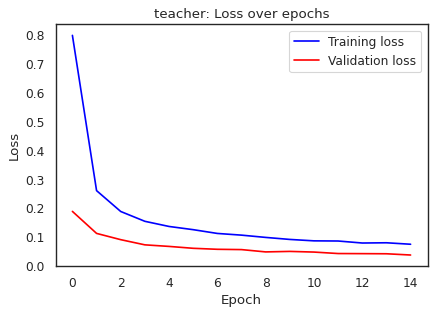

=======> Student model trained with Temperature 4
04:43:27 --- Epoch: 1	Train loss: 0.1451	Valid loss: 0.0496	Train accuracy: 97.58	Valid accuracy: 98.34
04:44:14 --- Epoch: 3	Train loss: 0.0751	Valid loss: 0.0431	Train accuracy: 98.01	Valid accuracy: 98.56
04:45:01 --- Epoch: 5	Train loss: 0.0575	Valid loss: 0.0427	Train accuracy: 98.08	Valid accuracy: 98.60
04:45:48 --- Epoch: 7	Train loss: 0.0497	Valid loss: 0.0419	Train accuracy: 98.11	Valid accuracy: 98.66
04:46:35 --- Epoch: 9	Train loss: 0.0441	Valid loss: 0.0404	Train accuracy: 98.16	Valid accuracy: 98.75
04:47:23 --- Epoch: 11	Train loss: 0.0409	Valid loss: 0.0395	Train accuracy: 98.23	Valid accuracy: 98.78
04:48:10 --- Epoch: 13	Train loss: 0.0385	Valid loss: 0.0396	Train accuracy: 98.22	Valid accuracy: 98.73


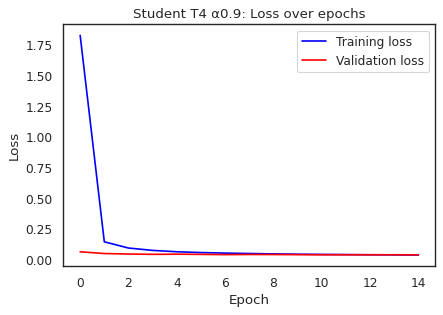


student model valid accuracy: 0.9874
=======> Temperature: 8
=======> Teacher model trained with Temperature 8
04:49:14 --- Epoch: 1	Train loss: 0.2621	Valid loss: 0.1184	Train accuracy: 94.83	Valid accuracy: 96.56
04:50:00 --- Epoch: 3	Train loss: 0.1568	Valid loss: 0.0753	Train accuracy: 96.58	Valid accuracy: 97.61
04:50:47 --- Epoch: 5	Train loss: 0.1231	Valid loss: 0.0684	Train accuracy: 97.25	Valid accuracy: 97.90
04:51:33 --- Epoch: 7	Train loss: 0.1051	Valid loss: 0.0503	Train accuracy: 97.73	Valid accuracy: 98.37
04:52:19 --- Epoch: 9	Train loss: 0.0927	Valid loss: 0.0464	Train accuracy: 97.95	Valid accuracy: 98.49
04:53:05 --- Epoch: 11	Train loss: 0.0859	Valid loss: 0.0430	Train accuracy: 98.25	Valid accuracy: 98.46
04:53:51 --- Epoch: 13	Train loss: 0.0765	Valid loss: 0.0424	Train accuracy: 98.39	Valid accuracy: 98.70


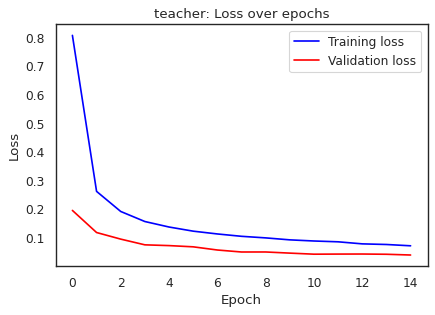

=======> Student model trained with Temperature 8
04:54:55 --- Epoch: 1	Train loss: 0.1680	Valid loss: 0.0505	Train accuracy: 97.63	Valid accuracy: 98.33
04:55:42 --- Epoch: 3	Train loss: 0.0931	Valid loss: 0.0442	Train accuracy: 98.03	Valid accuracy: 98.55
04:56:30 --- Epoch: 5	Train loss: 0.0740	Valid loss: 0.0435	Train accuracy: 98.19	Valid accuracy: 98.60
04:57:17 --- Epoch: 7	Train loss: 0.0647	Valid loss: 0.0420	Train accuracy: 98.17	Valid accuracy: 98.63
04:58:05 --- Epoch: 9	Train loss: 0.0584	Valid loss: 0.0425	Train accuracy: 98.26	Valid accuracy: 98.66
04:58:52 --- Epoch: 11	Train loss: 0.0539	Valid loss: 0.0411	Train accuracy: 98.32	Valid accuracy: 98.70
04:59:39 --- Epoch: 13	Train loss: 0.0501	Valid loss: 0.0412	Train accuracy: 98.35	Valid accuracy: 98.70


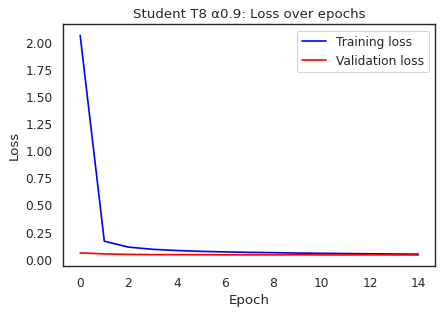


student model valid accuracy: 0.9876
=======> Temperature: 10
=======> Teacher model trained with Temperature 10
05:00:44 --- Epoch: 1	Train loss: 0.2590	Valid loss: 0.1175	Train accuracy: 94.70	Valid accuracy: 96.58
05:01:30 --- Epoch: 3	Train loss: 0.1549	Valid loss: 0.0750	Train accuracy: 96.48	Valid accuracy: 97.69
05:02:16 --- Epoch: 5	Train loss: 0.1229	Valid loss: 0.0632	Train accuracy: 97.30	Valid accuracy: 98.10
05:03:03 --- Epoch: 7	Train loss: 0.1041	Valid loss: 0.0558	Train accuracy: 97.66	Valid accuracy: 98.22
05:03:48 --- Epoch: 9	Train loss: 0.0931	Valid loss: 0.0491	Train accuracy: 97.91	Valid accuracy: 98.27
05:04:34 --- Epoch: 11	Train loss: 0.0843	Valid loss: 0.0430	Train accuracy: 98.23	Valid accuracy: 98.65
05:05:21 --- Epoch: 13	Train loss: 0.0783	Valid loss: 0.0394	Train accuracy: 98.34	Valid accuracy: 98.68


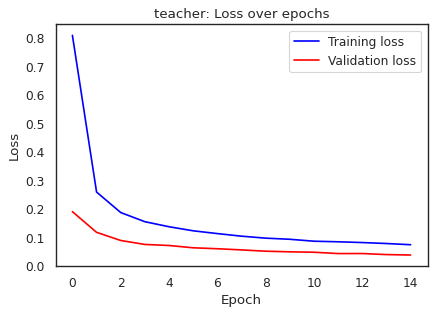

=======> Student model trained with Temperature 10
05:06:24 --- Epoch: 1	Train loss: 0.1690	Valid loss: 0.0508	Train accuracy: 97.52	Valid accuracy: 98.20
05:07:12 --- Epoch: 3	Train loss: 0.0940	Valid loss: 0.0436	Train accuracy: 97.89	Valid accuracy: 98.50
05:07:59 --- Epoch: 5	Train loss: 0.0748	Valid loss: 0.0426	Train accuracy: 98.03	Valid accuracy: 98.57
05:08:47 --- Epoch: 7	Train loss: 0.0650	Valid loss: 0.0405	Train accuracy: 98.09	Valid accuracy: 98.71
05:09:34 --- Epoch: 9	Train loss: 0.0588	Valid loss: 0.0407	Train accuracy: 98.16	Valid accuracy: 98.65
05:10:22 --- Epoch: 11	Train loss: 0.0544	Valid loss: 0.0408	Train accuracy: 98.15	Valid accuracy: 98.64
05:11:09 --- Epoch: 13	Train loss: 0.0505	Valid loss: 0.0400	Train accuracy: 98.15	Valid accuracy: 98.66


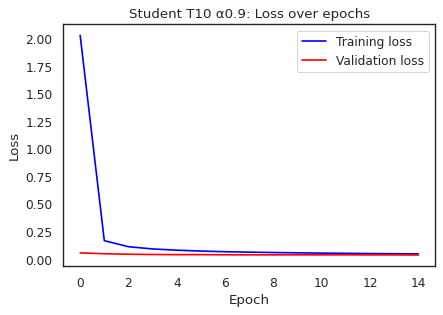


student model valid accuracy: 0.9870
=======> Temperature: 15
=======> Teacher model trained with Temperature 15
05:12:12 --- Epoch: 1	Train loss: 0.2584	Valid loss: 0.1082	Train accuracy: 94.75	Valid accuracy: 96.85
05:12:58 --- Epoch: 3	Train loss: 0.1560	Valid loss: 0.0723	Train accuracy: 96.72	Valid accuracy: 97.98
05:13:44 --- Epoch: 5	Train loss: 0.1229	Valid loss: 0.0616	Train accuracy: 97.34	Valid accuracy: 98.02
05:14:30 --- Epoch: 7	Train loss: 0.1053	Valid loss: 0.0507	Train accuracy: 97.70	Valid accuracy: 98.47
05:15:16 --- Epoch: 9	Train loss: 0.0900	Valid loss: 0.0506	Train accuracy: 97.96	Valid accuracy: 98.30
05:16:02 --- Epoch: 11	Train loss: 0.0845	Valid loss: 0.0489	Train accuracy: 98.01	Valid accuracy: 98.36
05:16:49 --- Epoch: 13	Train loss: 0.0763	Valid loss: 0.0436	Train accuracy: 98.32	Valid accuracy: 98.59


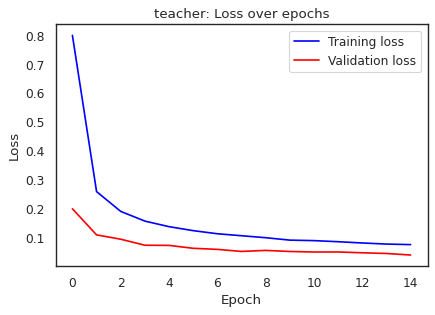

=======> Student model trained with Temperature 15
05:17:52 --- Epoch: 1	Train loss: 0.1641	Valid loss: 0.0493	Train accuracy: 97.62	Valid accuracy: 98.34
05:18:40 --- Epoch: 3	Train loss: 0.0939	Valid loss: 0.0439	Train accuracy: 97.94	Valid accuracy: 98.50
05:19:27 --- Epoch: 5	Train loss: 0.0748	Valid loss: 0.0430	Train accuracy: 98.10	Valid accuracy: 98.65
05:20:15 --- Epoch: 7	Train loss: 0.0650	Valid loss: 0.0421	Train accuracy: 98.21	Valid accuracy: 98.63
05:21:02 --- Epoch: 9	Train loss: 0.0589	Valid loss: 0.0407	Train accuracy: 98.26	Valid accuracy: 98.67
05:21:50 --- Epoch: 11	Train loss: 0.0538	Valid loss: 0.0407	Train accuracy: 98.26	Valid accuracy: 98.72
05:22:37 --- Epoch: 13	Train loss: 0.0506	Valid loss: 0.0400	Train accuracy: 98.23	Valid accuracy: 98.74


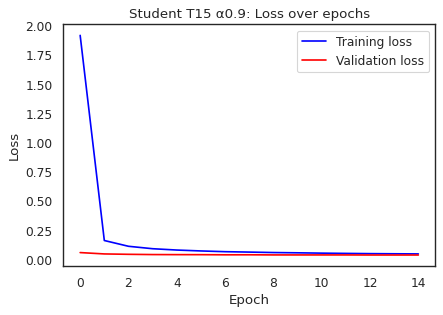


student model valid accuracy: 0.9864


In [10]:
# Train
LEARNING_RATE_T = 0.01
LEARNING_RATE_S = 0.015
N_EPOCHS = 15
ALPHA = 0.9

for T in [2, 3, 4, 8, 10, 15]:
    print(f"=======> Temperature: {T}")
    print(f"=======> Teacher model trained with Temperature {T}")
    model_teacher = LargeNet(N_CLASSES, DROPOUT, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE_T, momentum=0.9)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params, print_every=2)

    print(f"=======> Student model trained with Temperature {T}")
    model_s_soft = SmallNet(N_CLASSES, T).to(DEVICE)
    optimizer = torch.optim.SGD(model_s_soft.parameters(), lr=LEARNING_RATE_S, momentum=0.9)
    
    train_criterion = SoftCrossEntropyLoss(T, ALPHA)
    valid_criterion = nn.CrossEntropyLoss()
    
    prefix = f"student_T{T}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{T} α{ALPHA}"
         }

    model_s_soft, optimizer, _ = training_loop(model_s_soft, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, print_every=2, teacher_model=model_teacher)
    torch.save(model_s_soft.state_dict(), f"{dir_path}/{prefix}_parameters.pt")
    
    valid_acc = get_accuracy(model_s_soft, test_loader, DEVICE)
    print(f"\nstudent model valid accuracy: {valid_acc:.4f}")
